In [1]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot as plt
from bertopic import BERTopic
from datetime import datetime

In [2]:
import umap
import seaborn as sns
import numpy as np
import pandas as pd

## Lectura del dataset "app_reviews"

In [3]:
review = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')
review = review.drop(['date','star'],axis=1)
#review = pd.read_csv('C:/Users/USUARIO/Documents/Universidad/4A. Inteligencia Artificial/Dataset/app_reviews.csv')
review

,package_name,review
0,com.mantz_it.rfanalyzer,Great app! The new version now works on my Bra...
1,com.mantz_it.rfanalyzer,Great It's not fully optimised and has some is...
2,com.mantz_it.rfanalyzer,Works on a Nexus 6p I'm still messing around w...
3,com.mantz_it.rfanalyzer,The bandwidth seemed to be limited to maximum ...
4,com.mantz_it.rfanalyzer,Works well with my Hackrf Hopefully new update...
...,...,...
288060,com.termux.api,it doesn't do anything after installing this i...
288061,com.termux.api,I like this app . Its is very helpful for use....
288062,com.termux.api,Finally Brings back the Unix command line to A...
288063,com.termux.api,The API feature is great just need loads more...


### Se extrae en un corpus todos los reviews o criticas de usuario

In [4]:
def extract_corpus(dataset):
    print(datetime.today(), "extrayendo oraciones...")
    lista = []  
    for i in range(len(dataset['package_name'].unique())):#iterar entre los package_name unicos
        dataset_temp = dataset.loc[dataset['package_name'] == dataset['package_name'].unique()[i]]
        lista.append({'package_name':dataset['package_name'].unique()[i], 'size': len(dataset_temp)})#otener un package_name y el número de oraciones

    lista = sorted(lista, key=lambda x: x['size'], reverse=True)#se ordena para saber que package_name tiene el mayor n° de oraciones
    dataframe = dataset[dataset['package_name'] == lista[8]['package_name']]#el mayor será el elemnto que ocupa la posicion 0
    corpus = list(dataframe['review'])#extraemos un corpus
    
    #corpus = clean_corpus(corpus)

    return corpus

### Convertir datos en un Dataframe a un manejo más ágil

In [5]:
def convert_corpus_to_dataFrame(corpus):
    print(datetime.today(), "Convirtiendo las oraciones extraidas a un dataframe...")
    corpus_ds = {
        'Sentences' : corpus
    }

    dataset_new = pd.DataFrame(corpus_ds)
    return dataset_new

### Se crea una función que nos permita incrustar las oraciones, para esto usamos un modelo pre-entrenado de SBERT

In [6]:
def neural_embeddings(dataset):
    model_embedder = SentenceTransformer('all-MiniLM-L6-v2')#modelo pre-entrenado
    corpus = extract_corpus(dataset)#extraemos un corpus del dataset 
    print(datetime.today(), "Incrustando las oraciones...")
    embeddings = model_embedder.encode(corpus, 
                                        convert_to_tensor=False, 
                                        show_progress_bar=True) #generamos las incrustaciones 

    embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True) #normalizamos

    return embeddings, corpus

### Para obtener el "mejor" cluster aplicamos el método de la silueta

In [7]:
#en esta funcion hace la tarea de obtener el mejor k con agglomerative clustering
def silhoutte(dataset, attempts):
    embeddings, corpus = neural_embeddings(dataset)
    print(datetime.today(), "Calculando el mejor k...")
    scores_silhouette = [] #guardaremos todos los resultados del método de la silueta para devolver el mayor

    for k in range(2,attempts+1):
        agglomerative_clusterering = AgglomerativeClustering(n_clusters=k, 
                                                            affinity="cosine" , 
                                                            linkage="complete").fit(embeddings)
                                                            
        cluster_labels = agglomerative_clusterering.labels_

        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        scores_silhouette.append(silhouette_avg)

    return scores_silhouette

In [12]:
list(range(2,10))

[2, 3, 4, 5, 6, 7, 8, 9]

2022-08-25 20:40:07.061451 extrayendo oraciones...
2022-08-25 20:40:57.588577 Incrustando las oraciones...


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

2022-08-25 20:42:46.876520 Calculando el mejor k...


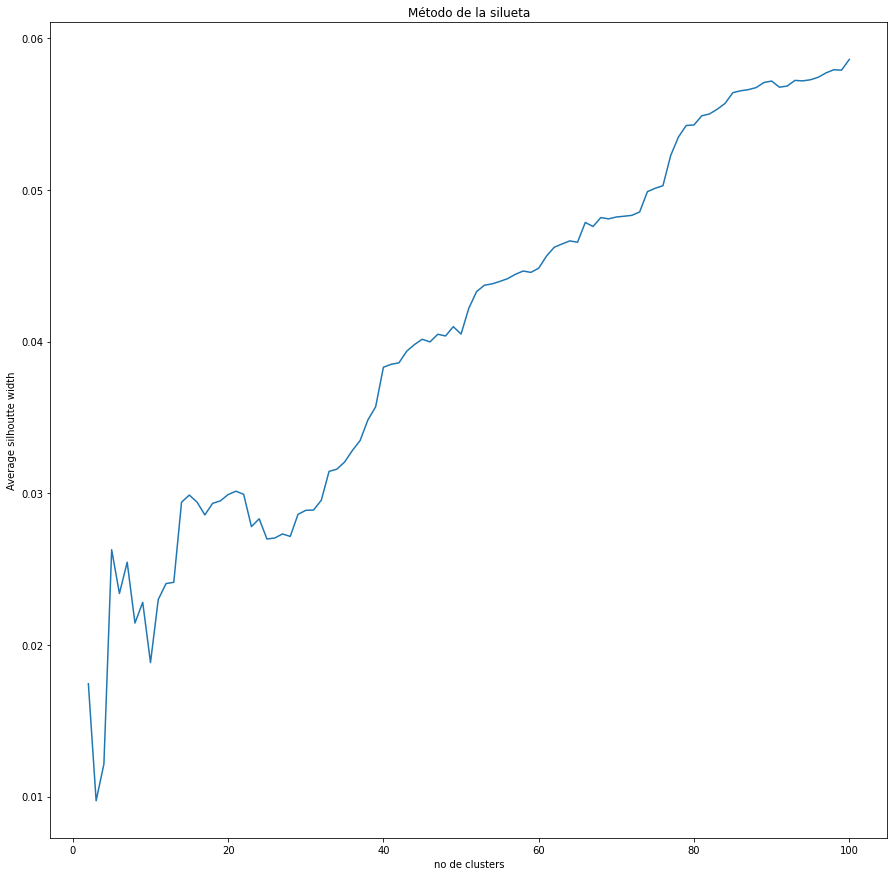

In [13]:
attempts = 100
score = silhoutte(review, attempts)

plt.figure(figsize=(15, 15))
plt.plot(range(2,attempts+1), score)
plt.title('Método de la silueta')
plt.xlabel('no de clusters')
plt.ylabel('Average silhoutte width')
plt.show()